# Exercises & extra-curriculum.

In [1]:
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Torch version: {torch.__version__}\nDevice available: {device}")

Torch version: 1.13.1+cu117
Device available: cpu


In [2]:
# GPU
!nvidia-smi

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.



#### **1.** Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

1. Train for more epochs, since we maybe just didn't converge to the best weights and biases we could get.

2. Adding complexity to our model so it can learn better patterns.

3. Using more quality on the images (for example, 224x244 pixels) so the model can learn more precise patterns.

#### **2.** Recreate the data loading functions we built in sections 1, 2, 3 and 4. You should have train and test DataLoader's ready to use.

In [3]:
# Download data if needed
import requests
import zipfile 
from pathlib import Path

# Paths
data_path = Path("./.data")
images_path = data_path/"pizza_steak_sushi"
train_path = images_path/"train"
test_path = images_path/"test"

# Making the directory
if images_path.is_dir():
    print(f"Directory '{images_path}' already exist, skipping this step.")
else:
    print(f"'{images_path}' doesn't exist, creating one...")
    images_path.mkdir(parents=True, exist_ok=True)

if not (images_path/"train").is_dir():
    # Download 
    with open(data_path/"pizza_steak_sushi.zip", "wb") as f:
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
        print(f"Downloading pizza, steak and sushi data...")
        f.write(request.content)

    # Unzip 
    with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
        print(f"Unziping pizza, steak and sushi data...")
        zip_ref.extractall(images_path)
else:
    print(f"Data is already donwloaded, skipping this step.")

Directory '.data/pizza_steak_sushi' already exist, skipping this step.
Data is already donwloaded, skipping this step.


In [4]:
# Some libs
import os
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List, Union, Optional

In [5]:
# Helper functions for the custom dataset
def find_classes(dir: str) -> Tuple[List[str], Dict[str, int]]:
    '''
    Finds the class folder names in a target directory
    '''
    
    # 1. Get class names by scanning the target dir
    classes = sorted([entry.name for entry in os.scandir(dir) if entry.is_dir()])
    
    # 2. Raise and error if can't be found 
    if not classes:
        raise FileNotFoundError(f"Couldn't find any classes in {dir}...")
    
    # 3. Create a dict of idx labels
    class_to_idx = {name: idx for idx, name in enumerate(classes)}
    
    return classes, class_to_idx

In [6]:
find_classes(str(train_path))[1]

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [7]:
# Custom DataSets (by subclassing Dataset)
# One for train and one for test 
class ImageFolderCustom(Dataset):
    def __init__(self,
                 target_dir: str,
                 transform) -> None:

        # Atributes
        self.paths: list = list(Path(target_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes: list
        self.class_to_idx: Dict[str, int]
        self.classes, self.class_to_idx = find_classes(dir=target_dir)
        
    def load_image(self,
                   idx: int) -> Image.Image:
        '''
        Opens an image via path and returns it
        '''
        image_path = self.paths[idx] # Path of "idx" image
        return Image.open(image_path) # Return the image with PIL.Image format
    
    # Overwrite len
    def __len__(self) -> int:
        '''
        Returns the number of samples
        '''
        return len(self.paths)
    
    # Overwrite getitem
    def __getitem__(self,
                    idx: int) -> Tuple[torch.Tensor, int]:
        '''
        Returns one sample of data, image & label, in a tuple.
        '''
        
        # Getting image in PIL.Image format & class name
        img = self.load_image(idx)
        class_name = self.paths[idx].parent.name
        
        # Get class label
        label = self.class_to_idx[class_name]

        return self.transform(img), label

In [8]:
from torchvision import transforms

IMAGE_SIZE = (64, 64)

train_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size=IMAGE_SIZE),
    transforms.ToTensor()
])

In [9]:
# Get DataSets
train_dataset = ImageFolderCustom(target_dir=str(train_path),
                                  transform=train_transform)
test_dataset = ImageFolderCustom(target_dir=str(test_path),
                                 transform=test_transform)
len(train_dataset), len(test_dataset)

(225, 75)

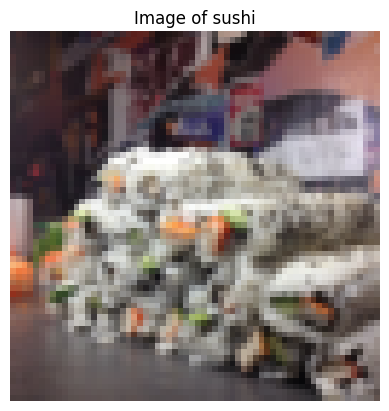

In [10]:
from random import randint
import matplotlib.pyplot as plt
# Making sure that the custom dataset is working correctly 
idx = randint(0, len(train_dataset))

img, label = train_dataset[idx]
plt.imshow(torch.Tensor(img).permute(1, 2, 0))
plt.axis(False)
plt.title(f"Image of {train_dataset.classes[label]}")
plt.show()

In [11]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32

# Get DataLoaders
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              num_workers=os.cpu_count())

test_dataloader = DataLoader(dataset=test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=os.cpu_count())
len(train_dataloader), len(test_dataloader)

(8, 3)

In [12]:
# Make sure everything works well
img, label = list(train_dataloader)[0]
img.shape

torch.Size([32, 3, 64, 64])

#### **3.** Recreate model_0 we built in section 7.

In [13]:
from torch import nn
class TinyVGG(nn.Module):
    def __init__(self,
                 in_c:int,
                 out_f:int,
                 hidden_units:int) -> None:
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=in_c,
                      out_channels=hidden_units,
                      stride=1,
                      padding=0,
                      kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      padding=0,
                      kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)
        )
        self.conv_block2 = nn.Sequential(
          nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      padding=0,
                      kernel_size=(3,3)),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      stride=1,
                      padding=0,
                      kernel_size=(3,3)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),
                         stride=2)  
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13,
                      out_features=out_f)
        )
        
        
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.classifier(self.conv_block2(self.conv_block1(x)))

In [14]:
# Making a prediction
tmp = TinyVGG(in_c=3,
              out_f=len(train_dataset.classes),
              hidden_units=10)
tmp(train_dataset[0][0].unsqueeze(dim=0)).shape

torch.Size([1, 3])

#### **4.** Create training and testing functions for model_0.

##### 4.1 Train and test steps

In [15]:
from torch.utils.data import DataLoader

def train_step(model: torch.nn.Module,
               train_dataloader: DataLoader,
               dev:str,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer) -> tuple:
    
    '''
    Performs a train step (you should call this function once per epoch).
    Returns test loss & test accuracy 
    '''
    
    # Training mode
    model.train()
    
    # Train loss & accuracy
    train_acc, train_loss = 0, 0
    
    # Loop through batches
    for batch, (X, y) in enumerate(train_dataloader):
        
        # Send to device 
        X, y = X.to(dev), y.to(dev)
        
        # Logits
        logits = model(X)
        y_pred = torch.argmax(logits, dim=1)
        
        # Loss & acc
        batch_loss = loss_fn(logits, y)
        batch_acc = (y_pred==y).sum().item()/(len(y_pred))

        train_loss += batch_loss
        train_acc += batch_acc
        
        # Zero grad, backward propagation & gradient descent 
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    # Adjust loss &  acc
    train_loss/=len(train_dataloader)
    train_acc/=len(train_dataloader)
        
    return train_loss, train_acc

In [16]:
def test_step(model: torch.nn.Module,
               test_dataloader: DataLoader,
               dev:str,
               loss_fn:torch.nn.Module) -> tuple:
    
    '''
    Performs a test step (you should call this function once per epoch).
    Returns test loss & test accuracy 
    '''
    
    test_loss, test_acc = 0, 0
    # Inference mode + evaluation
    with torch.inference_mode():
        model.eval()
    
        # Loop through batches
        for batch, (X, y) in enumerate(test_dataloader):
            
            X, y = X.to(dev), y.to(dev)
            
            # Logits & prediction
            logits = model(X)
            y_pred = torch.argmax(logits, dim=1)
            
            # Acc & loss
            test_loss += loss_fn(logits, y)
            test_acc += (y_pred==y).sum().item()/(len(y_pred))
            
        # Adjust loss & acc
        test_loss/=len(test_dataloader)
        test_acc/=len(test_dataloader)
            
            
    return test_loss, test_acc

##### 4.2 Train function

In [17]:
import pandas as pd 

def train(model: torch.nn.Module,
          train_dataloader: DataLoader,
          test_dataloader: DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module,
          EPOCHS:int,
          dev:str) -> Dict[str, int]:
    
    '''
    Performs the train using the data and model given.
    Returns a dictionary with the results.
    '''
    
    # Results dictionary
    results_dict: dict = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    for epoch in range(EPOCHS):
        
        # Train step
        train_results: tuple = train_step(model=model,
                                        train_dataloader=train_dataloader,
                                        dev=dev,
                                        loss_fn=loss_fn,
                                        optimizer=optimizer)
          
        # Test step
        test_results: tuple = test_step(model=model,
                                        test_dataloader=test_dataloader,
                                        dev=dev,
                                        loss_fn=loss_fn)  

        # Print out what's happening plus saving results 
        print(f"Train:\n\tLoss --> {train_results[0]:.4f}\n\tAccuracy --> {train_results[1]:.2f}")
        print(f"Test:\n\tLoss --> {test_results[0]:.4f}\n\tAccuracy --> {test_results[1]:.2f}")
        
        results_dict["train_loss"].append(train_results[0].item())
        results_dict["train_acc"].append(train_results[1])
        results_dict["test_loss"].append(test_results[0].item())
        results_dict["test_acc"].append(test_results[1])

    return results_dict

#### **5.** Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?

Note: `torch.optim.Adam()` with a learning rate of 0.001

In [18]:
experiments = [5, 20, 50]
results: Dict[str, dict] = {}

for epochs in experiments:
    print(f"------------- Trying with {epochs} epochs -------------")

    # Create a TinyVGG instance
    model = TinyVGG(in_c=3,
                    out_f=len(train_dataset.classes),
                    hidden_units=10).to(device)

    # Optimizer & Loss
    optimizer = torch.optim.Adam(params=model.parameters(),
                                lr=0.001)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Train and save results
    results[f"{epochs}epochs"] = train(
        model=model,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        optimizer=optimizer,
        loss_fn=loss_fn,
        EPOCHS=epochs,
        dev=device)

------------- Trying with 5 epochs -------------
Train:
	Loss --> 1.1000
	Accuracy --> 0.30
Test:
	Loss --> 1.0522
	Accuracy --> 0.48
Train:
	Loss --> 1.0726
	Accuracy --> 0.33
Test:
	Loss --> 1.0231
	Accuracy --> 0.52
Train:
	Loss --> 1.0420
	Accuracy --> 0.43
Test:
	Loss --> 1.0070
	Accuracy --> 0.49
Train:
	Loss --> 0.9834
	Accuracy --> 0.45
Test:
	Loss --> 0.9793
	Accuracy --> 0.50
Train:
	Loss --> 1.0274
	Accuracy --> 0.48
Test:
	Loss --> 0.9969
	Accuracy --> 0.50
------------- Trying with 20 epochs -------------
Train:
	Loss --> 1.1063
	Accuracy --> 0.28
Test:
	Loss --> 1.0988
	Accuracy --> 0.32
Train:
	Loss --> 1.0977
	Accuracy --> 0.30
Test:
	Loss --> 1.0954
	Accuracy --> 0.48
Train:
	Loss --> 1.0920
	Accuracy --> 0.52
Test:
	Loss --> 1.0832
	Accuracy --> 0.46
Train:
	Loss --> 1.0863
	Accuracy --> 0.33
Test:
	Loss --> 1.0635
	Accuracy --> 0.49
Train:
	Loss --> 1.0618
	Accuracy --> 0.52
Test:
	Loss --> 1.0353
	Accuracy --> 0.46
Train:
	Loss --> 1.0572
	Accuracy --> 0.37
Test:
	L

In [19]:
def plot_results(results: Dict[str, List[float]]):
    
    '''
    Plots the loss & accuracy for train and test.
    '''
    
    # "Y" axis
    y = range(len(results["train_loss"]))
    
    # Figure    
    plt.figure(figsize=(10, 3))
    
    # Loss
    plt.subplot(1, 2, 1)
    
    ## Train
    plt.plot(y, results["train_loss"], label="Train loss")    
    ## Test
    plt.plot(y, results["test_loss"], label="Test loss")
   
    plt.xlabel("Epochs")
    plt.title("Loss")
    plt.legend()
    
    # Accuracy
    plt.subplot(1, 2, 2)
    
    ## Train
    plt.plot(y, results["train_acc"], label="Train accuracy")    
    ## Test
    plt.plot(y, results["test_acc"], label="Test accuracy")
    
    plt.xlabel("Epochs")
    plt.title("Accuracy")
    plt.legend()
    
    plt.show()

---------Results with 5epochs---------


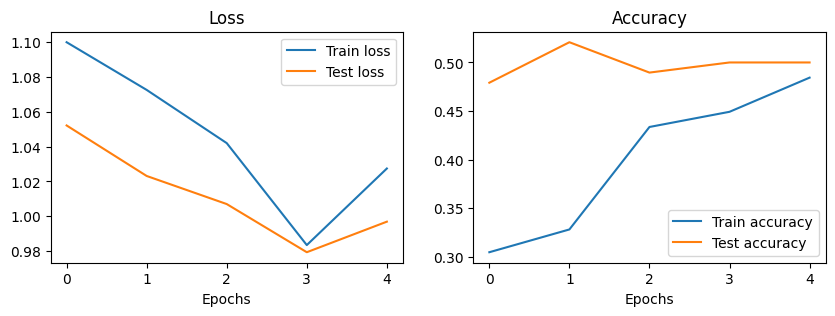

---------Results with 20epochs---------


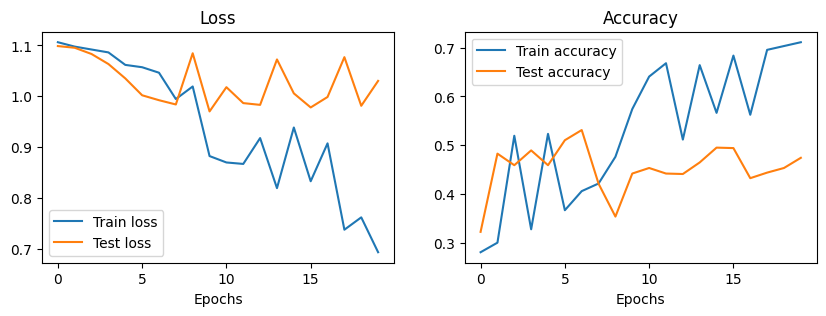

---------Results with 50epochs---------


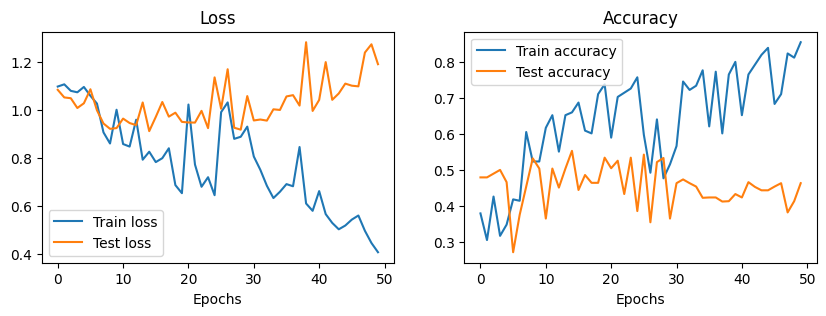

In [20]:
for key in results.keys():
    print(f"---------Results with {key}---------")
    plot_results(results[key])


Clearly we can se that, at certain point, training for more epochs just generate an incredible overfitting. The threshold should be in between 10 and 13 epochs (more or less).

#### **6.** Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [36]:
print(f"------------- Trying with 20 epochs -------------")

# Create a TinyVGG instance
model = TinyVGG(in_c=3,
                out_f=len(train_dataset.classes),
                hidden_units=20).to(device)

# Optimizer & Loss
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

epochs = 20
# Train and save results
results[f"20 epochs"] = train(
    model=model,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    optimizer=optimizer,
    loss_fn=loss_fn,
    EPOCHS=epochs,
    dev=device)

------------- Trying with 20 epochs -------------
Train:
	Loss --> 1.1029
	Accuracy --> 0.26
Test:
	Loss --> 1.0923
	Accuracy --> 0.53
Train:
	Loss --> 1.0945
	Accuracy --> 0.38
Test:
	Loss --> 1.0713
	Accuracy --> 0.46
Train:
	Loss --> 1.0233
	Accuracy --> 0.48
Test:
	Loss --> 1.0134
	Accuracy --> 0.43
Train:
	Loss --> 0.9623
	Accuracy --> 0.40
Test:
	Loss --> 0.9796
	Accuracy --> 0.50
Train:
	Loss --> 0.9152
	Accuracy --> 0.61
Test:
	Loss --> 1.0725
	Accuracy --> 0.43
Train:
	Loss --> 0.8610
	Accuracy --> 0.66
Test:
	Loss --> 0.9691
	Accuracy --> 0.47
Train:
	Loss --> 0.8586
	Accuracy --> 0.61
Test:
	Loss --> 1.0192
	Accuracy --> 0.45
Train:
	Loss --> 0.7751
	Accuracy --> 0.66
Test:
	Loss --> 1.0428
	Accuracy --> 0.45
Train:
	Loss --> 0.9484
	Accuracy --> 0.56
Test:
	Loss --> 1.0349
	Accuracy --> 0.50
Train:
	Loss --> 0.7602
	Accuracy --> 0.68
Test:
	Loss --> 1.0182
	Accuracy --> 0.45
Train:
	Loss --> 0.8426
	Accuracy --> 0.61
Test:
	Loss --> 1.0710
	Accuracy --> 0.49
Train:
	Loss --

------------------------ Results with 20 epochs and 20 hidden units ------------------------


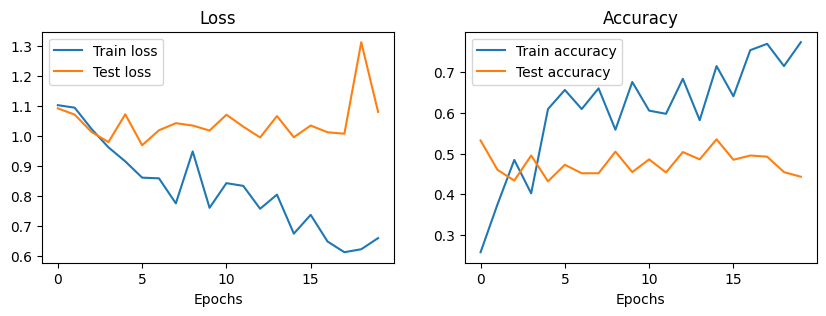

------------------------ Results with 20 epochs and 10 hidden units ------------------------


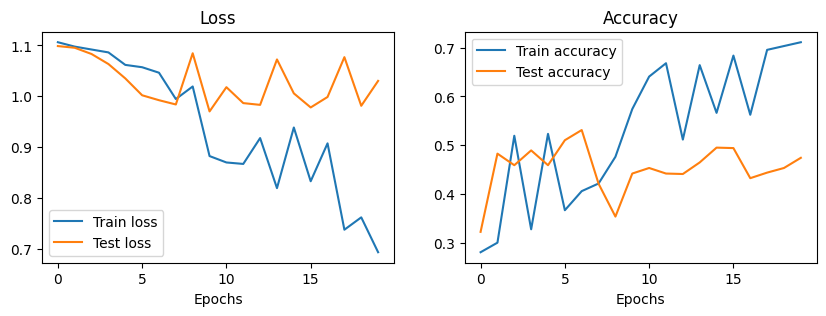

In [39]:
print(f"------------------------ Results with 20 epochs and 20 hidden units ------------------------")
plot_results(results=results["20 epochs"])
print(f"------------------------ Results with 20 epochs and 10 hidden units ------------------------")
plot_results(results["20epochs"])

Now, because model is more complex, if we compare with 20 epochs and just 10 hidden units, the training is more stable and overfits a bit less, but at the end the model is overfitting anyways.

#### **7 .** Double the data you're using with your model and train it for 20 epochs, what happens to the results?
* **Note**: You can use the custom data creation notebook to scale up your Food101 dataset.
* You can also find the already formatted double data (20% instead of 10% subset) dataset on GitHub, you will need to write download code like in exercise 2 to get it into this notebook.

##### 7.1 Get the data

In [23]:
images_path_2 = data_path/"pizza_steak_sushi_20%"

# Creating dir if needed
if images_path_2.is_dir():
    print(f"Directory '{images_path_2} already exists, skipping this step.'")
else:
    print(f"'{images_path_2}' doesn't exist, creating one...")
    images_path_2.mkdir(parents=True, exist_ok=True)

# Download if needed 
if not (images_path_2/"train").is_dir():
    
    # Download
    with open(data_path/"pizza_steak_sushi_20%.zip", "wb") as f:
        print(f"Downloading data...")
        request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip")
        f.write(request.content)
    
    # Unzip
    with zipfile.ZipFile(data_path/"pizza_steak_sushi_20%.zip", "r") as zip_ref:
        print(f"Uzipping data...")
        zip_ref.extractall(images_path_2)
        
else:
    print(f"Data already downloaded, skipping this step.")

Directory '.data/pizza_steak_sushi_20% already exists, skipping this step.'
Data already downloaded, skipping this step.


##### 7.2 Getting the Dataset and the DataLoader

In [24]:
# Datasets
train_dataset_20per = ImageFolderCustom(target_dir=str(images_path_2/"train"),
                                        transform=train_transform)
test_dataset_20per = ImageFolderCustom(target_dir=str(images_path_2/"test"),
                                       transform=test_transform)

# DataLoaders 
train_dataloader_20per = DataLoader(dataset=train_dataset_20per,
                                    batch_size=BATCH_SIZE,
                                    shuffle=True,
                                    num_workers=os.cpu_count())

test_dataloader_20per = DataLoader(dataset=test_dataset_20per,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=os.cpu_count())

In [25]:
len(train_dataset_20per), len(test_dataset_20per)

(450, 150)

In [26]:
len(train_dataloader_20per), len(test_dataloader_20per)

(15, 5)

##### 7.3 Train the model again

In [27]:
print(f"------------- Trying with 20 epochs -------------")

# Create a TinyVGG instance
model = TinyVGG(in_c=3,
                out_f=len(train_dataset_20per.classes),
                hidden_units=20).to(device)

# Optimizer & Loss
optimizer = torch.optim.Adam(params=model.parameters(),
                            lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Train and save results
results[f"20 epochs"] = train(
    model=model,
    train_dataloader=train_dataloader_20per,
    test_dataloader=test_dataloader_20per,
    optimizer=optimizer,
    loss_fn=loss_fn,
    EPOCHS=epochs,
    dev=device)

------------- Trying with 20 epochs -------------
Train:
	Loss --> 1.1040
	Accuracy --> 0.30
Test:
	Loss --> 1.0947
	Accuracy --> 0.33
Train:
	Loss --> 1.0840
	Accuracy --> 0.45
Test:
	Loss --> 1.0672
	Accuracy --> 0.42
Train:
	Loss --> 1.0243
	Accuracy --> 0.45
Test:
	Loss --> 0.9662
	Accuracy --> 0.60
Train:
	Loss --> 0.9999
	Accuracy --> 0.53
Test:
	Loss --> 0.9126
	Accuracy --> 0.47
Train:
	Loss --> 0.9706
	Accuracy --> 0.52
Test:
	Loss --> 0.9077
	Accuracy --> 0.63
Train:
	Loss --> 0.8782
	Accuracy --> 0.60
Test:
	Loss --> 0.9036
	Accuracy --> 0.63
Train:
	Loss --> 0.8821
	Accuracy --> 0.62
Test:
	Loss --> 0.9305
	Accuracy --> 0.50
Train:
	Loss --> 0.8905
	Accuracy --> 0.59
Test:
	Loss --> 0.8938
	Accuracy --> 0.60
Train:
	Loss --> 0.8681
	Accuracy --> 0.62
Test:
	Loss --> 0.9553
	Accuracy --> 0.53
Train:
	Loss --> 0.8574
	Accuracy --> 0.61
Test:
	Loss --> 0.9002
	Accuracy --> 0.50
Train:
	Loss --> 0.8905
	Accuracy --> 0.56
Test:
	Loss --> 0.9126
	Accuracy --> 0.61
Train:
	Loss --

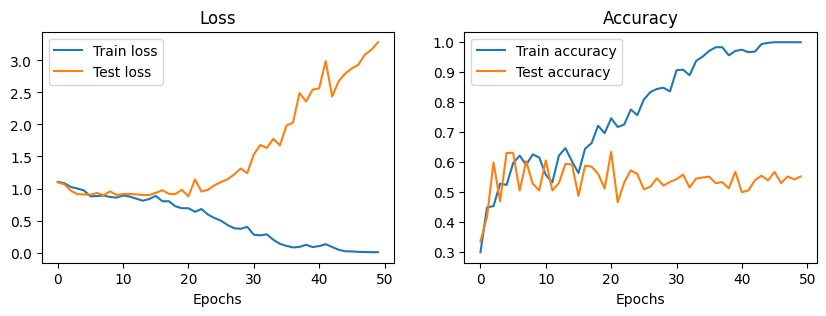

In [28]:
plot_results(results=results["20 epochs"])

With the double amount of data and the same hyperparameters than before (20 hidden units plus 20 training epochs) we achived some better results in the threshold (8-10 epochs), but the overfit happens again after that.

#### **8 .** Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) and share your prediction.

* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [29]:
# Get the custom image 
import requests 
custom_image_path = "./.data/custom_image.jpg"
url = "https://imgs.search.brave.com/3Ul7nnUJ3C532AlLy9D_RXR98XL4CRDzLN0gFf_Y-x8/rs:fit:860:0:0:0/g:ce/aHR0cHM6Ly9saDUu/Z29vZ2xldXNlcmNv/bnRlbnQuY29tL3Av/QUYxUWlwTkpmRUFx/a3hnVGZqektTZUwt/ekRGc0Q2VFBKWVYz/bjA0VVRCeUk9dzgw/MC1oNTAwLWstbm8"
resp = requests.get(url)
with open(custom_image_path, "wb") as f:
    f.write(resp.content)

In [30]:
# Prepare data
img = torchvision.io.read_image(custom_image_path)
real_class = "sushi"
label = train_dataset.class_to_idx[real_class]
print(f"We got an image of a {real_class} (label --> {label})")

# Transform img 
transform = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
])
img = transform(img)/255
print(f"Image shape: {img.shape}")
img

We got an image of a sushi (label --> 2)
Image shape: torch.Size([3, 64, 64])


tensor([[[0.3529, 0.3451, 0.3020,  ..., 0.1020, 0.1137, 0.1059],
         [0.3294, 0.3059, 0.2941,  ..., 0.1333, 0.1059, 0.0980],
         [0.2980, 0.2863, 0.2588,  ..., 0.1098, 0.0902, 0.0941],
         ...,
         [0.5412, 0.4510, 0.4118,  ..., 0.2549, 0.2627, 0.2588],
         [0.3373, 0.3412, 0.3569,  ..., 0.2314, 0.2314, 0.2471],
         [0.3137, 0.3176, 0.3098,  ..., 0.2235, 0.2314, 0.2471]],

        [[0.2471, 0.2510, 0.2235,  ..., 0.2196, 0.2314, 0.2235],
         [0.2235, 0.2118, 0.2118,  ..., 0.2510, 0.2235, 0.2157],
         [0.1922, 0.1922, 0.1765,  ..., 0.2275, 0.2078, 0.2118],
         ...,
         [0.4941, 0.4000, 0.3608,  ..., 0.2275, 0.2353, 0.2314],
         [0.2941, 0.2980, 0.3137,  ..., 0.2039, 0.2039, 0.2196],
         [0.2745, 0.2824, 0.2745,  ..., 0.1961, 0.2039, 0.2196]],

        [[0.1529, 0.1569, 0.1294,  ..., 0.2549, 0.2706, 0.2627],
         [0.1294, 0.1255, 0.1373,  ..., 0.2902, 0.2627, 0.2549],
         [0.1059, 0.1020, 0.1020,  ..., 0.2667, 0.2471, 0.

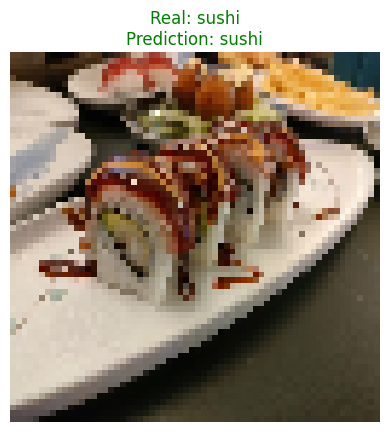

In [31]:
# Prediction
with torch.inference_mode():
    model.eval()
    
    logits = model(img.unsqueeze(dim=0).to(device))
    pred = torch.argmax(logits, dim=1)
    

# Plot 
plt.imshow(img.permute(1, 2, 0))
plt.axis(False)
title = f"Real: {real_class}\nPrediction: {train_dataset_20per.classes[pred]}"
if pred.item() == label:
    plt.title(title, c="g")
else:
    plt.title(title, c="r")

The model couldn't predict correctly the image. 

What could we do?

* Add more complexity to our model so it can learn better patterns (more hidden units, more conv blocks, ...). 

* Use better image quality (224x244 pixels, for example).

* Use more images, since this dataset has not a lot (we saw some improves when we went from 10% of original dataset to 20%).

* **EXTRA**: Reduce overfitting with other techniques so we can train for longer (dropout, regularization, ...)